In [45]:
import networkx as nx
import random
import plotly as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import math

import torch_geometric.data

from preprocessing import Preprocessing as pp
from classes import transportnetwork as tn

In [35]:
G = pp.create_network_from_trailway('../../../data/Railway Data_JL.xlsx')
TN = tn.TransportNetwork(G, pos_argument=["lon", "lat"], time_arguments=["dep_time", "arr_time"], nodes_weight_argument="lat", edges_weight_argument="train_max_speed")

Network creation: 


100%|██████████| 69638/69638 [00:04<00:00, 15835.66it/s]


In [71]:
#TODO add this as a function in DefaultCharVis
# Check if dirgraph or not
# if dir, both out and in, else edges
outDegrees = list(dict(TN.dirgraph.out_degree).values())
inDegrees = list(dict(TN.dirgraph.in_degree).values())

df = pd.DataFrame({"out": outDegrees, "in": inDegrees})

df

px.histogram(df)

In [ ]:
from CharVis import DefaultCharVis as dfc
from preprocessing import Preprocessing as pp
from classes import transportnetwork as tn
import ipywidgets as widgets

G = pp.create_network_from_trailway('../../../data/Railway Data_JL.xlsx')
TN = tn.TransportNetwork(G, pos_argument=["lon", "lat"], time_arguments=["dep_time", "arr_time"],
                                 nodes_weight_argument="lat", edges_weight_argument="train_max_speed")

disp_out_edges = True

dfc.plot_hist_degrees(TN)

def printMap(TN, out_edges):
    dfc.map_degrees(TN, out_edges)

def on_button_clicked():
    global disp_out_edges
    printMap(TN, disp_out_edges)
    temp = disp_out_edges
    if temp:
        disp_out_edges = False
    else:
        disp_out_edges = True

widgets.interact_manual(on_button_clicked)

Network creation: 


100%|██████████| 69638/69638 [00:06<00:00, 10771.19it/s]


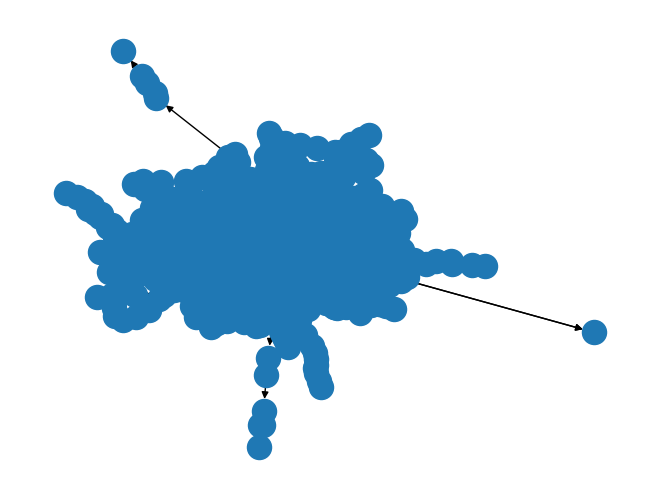

In [7]:
import torch
import torch_geometric as tg
from torch_geometric.data import Data
import networkx as nx
from CharVis import DefaultCharVis as dfc
from preprocessing import Preprocessing as pp
import numpy as np
from sklearn.preprocessing import StandardScaler
from classes import transportnetwork as tn

G = pp.create_network_from_trailway('../../../data/Railway Data_JL.xlsx')
TN = tn.TransportNetwork(G, pos_argument=["lon", "lat"], time_arguments=["dep_time", "arr_time"],
                                 nodes_weight_argument="lat", edges_weight_argument="train_max_speed")

nx.draw(G)


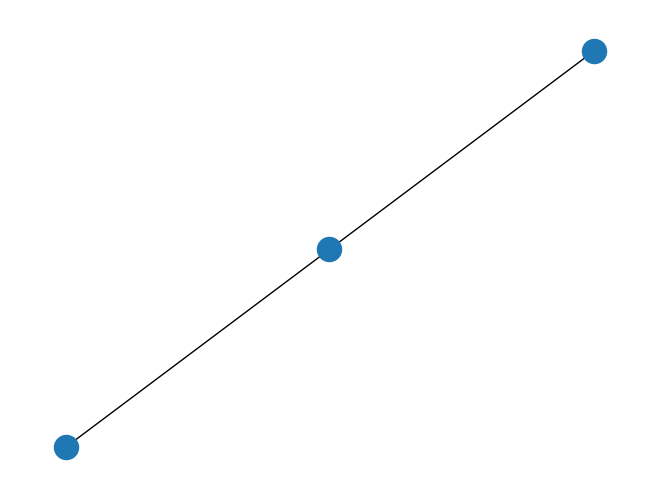

In [5]:
import torch
import torch_geometric as tg
from torch_geometric.data import Data
import networkx as nx

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
Data(edge_index=[2, 4], x=[3, 1])
g = tg.utils.to_networkx(data, to_undirected=True)
nx.draw(g)

In [13]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from preprocessing import Preprocessing as pp
from classes import transportnetwork as tn
import pandas as pd
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Processing...
Done!


Accuracy: 0.7990
